# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

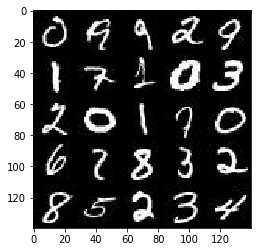

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

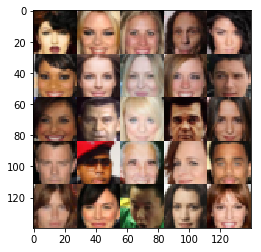

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype = tf.float32, shape = (None, image_width, image_height, image_channels),
                                 name = 'real_images')
    #print (image_width, image_height, image_channels)
    
    z_input = tf.placeholder(dtype = tf.float32, shape = (None, z_dim), name = 'z_input')
    learing_rate = tf.placeholder(dtype = tf.float32, shape = None, name = 'lr')

    return real_images, z_input, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leakyRelu(x, reuse = False, leak = 0.2, name = 'lrelu'):
    #with tf.variable_scope(name, reuse):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # With a wave of my wand, I generate . . . MAGIC NUMBERS! WHAM-BAM-ALAKAZAM
        d1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        relu1 = leakyRelu(d1)
        #print(relu1.get_shape().as_list())
        
        d2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        bn2 = tf.layers.batch_normalization(d2, training = True)
        relu2 = leakyRelu(bn2)
        #print(relu2.get_shape().as_list())
        
        d3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        bn3 = tf.layers.batch_normalization(d3, training = True)
        relu3 = leakyRelu(bn3)
        #print(relu3.get_shape().as_list())
        
        d4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        bn4 = tf.layers.batch_normalization(d4, training = True)
        relu4 = leakyRelu(bn4)
        #print(relu4.get_shape().as_list())
        
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1, 
                                kernel_initializer = tf.random_normal_initializer(stddev = 0.05))
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2 
    
    # Alright Mr. Forums-guy, I'll try that, but it can't possibly be righ- oh fark me.
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # WHA-FLA-ABRACADABRA
        l1 = tf.layers.dense(z, 7*7*768)
        
        l1 = tf.reshape(l1, (-1, 7, 7, 768))
        l1 = tf.layers.batch_normalization(l1, training = is_train)
        l1 = tf.maximum(alpha * l1, l1)
        #print(l1.get_shape().as_list())
        
        l2 = tf.layers.conv2d_transpose(l1, 512, 4, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training = is_train)
        l2 = tf.maximum(alpha * l2, l2)
        #print(l2.get_shape().as_list())
        
        l3 = tf.layers.conv2d_transpose(l2, 256, 4, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training = is_train)
        l3 = tf.maximum(alpha * l3, l3)
        #print(l3.get_shape().as_list())
        
        l4 = tf.layers.conv2d_transpose(l3, 128, 4, strides = 1, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        l4 = tf.layers.batch_normalization(l4, training = is_train)
        l4 = tf.maximum(alpha * l4, l4)
        #print(l4.get_shape().as_list())
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 4, strides = 1, padding = 'same', 
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen, reuse = True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real, 
                                                labels = tf.ones_like(dis_model_real) * np.random.uniform(0.7, 1.2)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_fake + dis_loss_real
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    

    # Book keeping
    print_every, show_every = 10, 100    
    _, image_width, image_height, image_channels = data_shape
    steps = 0
    losses = []
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                noize = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: noize})
                sess.run(g_opt, feed_dict = {input_z: noize, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = {input_real: batch_images, input_z: noize})
                    train_loss_g = g_loss.eval({input_z: noize})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                            'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                            'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    # gen_samples = sess.run(
                    #               generator(input_z, image_channels, reuse = True, training = False),
                    #               feed_dict = {input_z: sample_z})
                    # samples.append(gen_samples)
                                 
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
            # show final each epoch
            show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 5.6016
Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 2.9840
Epoch 1/2... Discriminator Loss: 4.4355... Generator Loss: 0.0585
Epoch 1/2... Discriminator Loss: 3.5302... Generator Loss: 0.0732
Epoch 1/2... Discriminator Loss: 2.4608... Generator Loss: 0.1788
Epoch 1/2... Discriminator Loss: 2.0689... Generator Loss: 0.2801
Epoch 1/2... Discriminator Loss: 1.9774... Generator Loss: 0.3258
Epoch 1/2... Discriminator Loss: 1.9205... Generator Loss: 0.3266
Epoch 1/2... Discriminator Loss: 1.7914... Generator Loss: 0.3684
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.3820


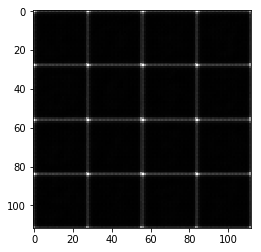

Epoch 1/2... Discriminator Loss: 1.5139... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.5642... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.7166... Generator Loss: 0.3902
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.6523... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 1.6012... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4961


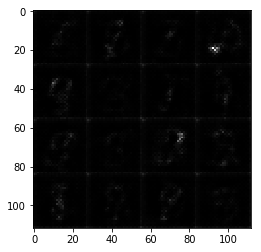

Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 1.0920
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.6617... Generator Loss: 0.4241
Epoch 1/2... Discriminator Loss: 1.5137... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.5046
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.5795
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 1.0381
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.5874


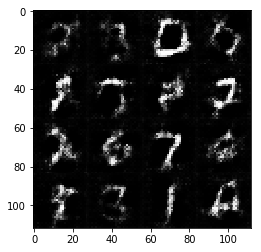

Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 1.3350
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 0.3602
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 1.3365
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.6781
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 1.2920
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.6027


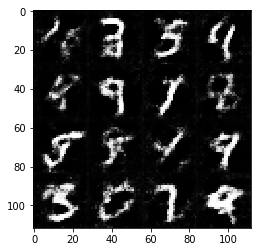

Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 1.2463
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.6888... Generator Loss: 0.4016
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 1.1796
Epoch 1/2... Discriminator Loss: 1.6281... Generator Loss: 0.4310
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 0.5666


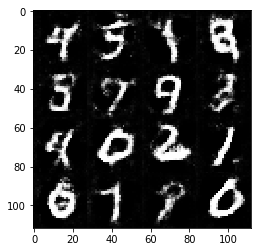

Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 1.6668
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 1.6643
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 1.6162... Generator Loss: 2.0452
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.8077


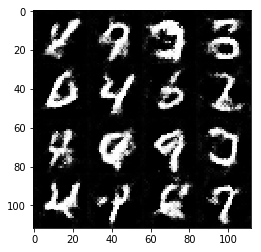

Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 1.5898
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 1.1359
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.3165
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 1.0921


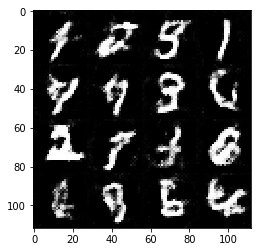

Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.5967... Generator Loss: 0.4376
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.6248... Generator Loss: 0.4328
Epoch 1/2... Discriminator Loss: 1.6377... Generator Loss: 0.4419
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 1.5300
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 1.4694
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.7720


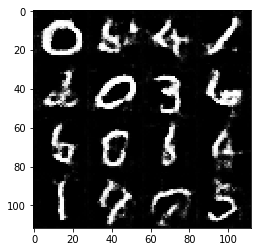

Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 1.5429... Generator Loss: 1.6521
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.7258... Generator Loss: 0.3959
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.6735... Generator Loss: 0.4063
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.5482
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 1.1841


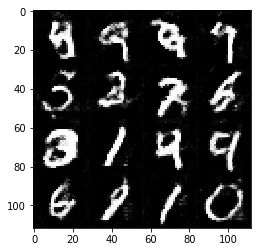

Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.5997
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.6559


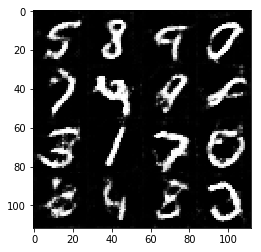

Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 1.4026
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 1.3762
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.6822


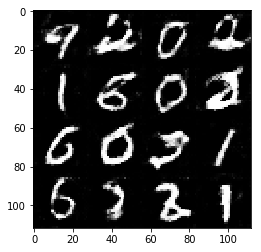

Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.4549... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.4274
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 1.6859... Generator Loss: 0.4032
Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.7408... Generator Loss: 0.3759


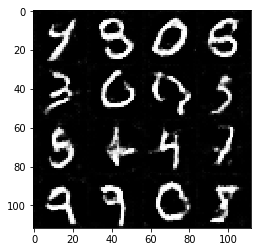

Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.5154
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.4905... Generator Loss: 0.5136
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.4986... Generator Loss: 0.5206
Epoch 2/2... Discriminator Loss: 1.6037... Generator Loss: 0.4328


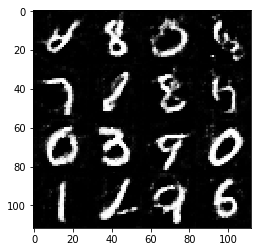

Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6820
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.4613
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.5720
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.8869


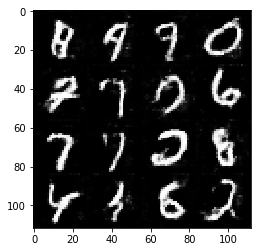

Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 1.0150


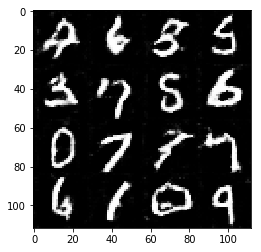

Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 1.2273
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 1.2203
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 1.2059
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 0.9393
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.5598


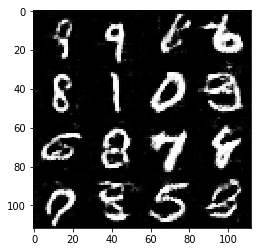

Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 1.0027
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.5842


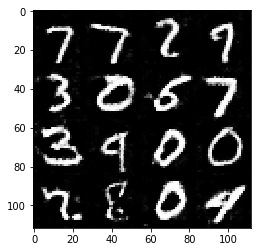

Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.5744
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.2195
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.5545
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 1.2650
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 1.1215
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 2.1246... Generator Loss: 2.1849


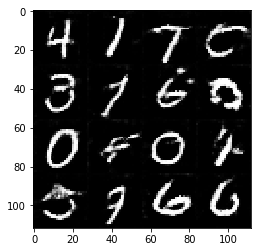

Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 1.3285
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.2025
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 1.2264
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.7323


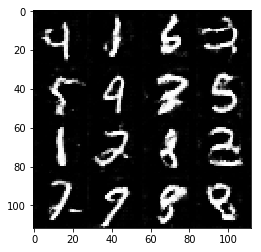

Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.8410
Epoch 2/2... Discriminator Loss: 1.3448... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.2807... Generator Loss: 1.2773
Epoch 2/2... Discriminator Loss: 1.9984... Generator Loss: 2.0789
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.5364


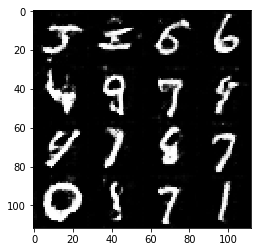

In [ ]:
batch_size = 64
z_dim = 100 # was 64
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9033... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 2.2451... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 1.8065... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 2.2936... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 2.0900... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 2.6109


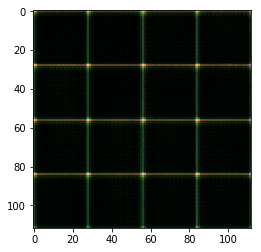

Epoch 1/1... Discriminator Loss: 1.7082... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 2.4592... Generator Loss: 0.1831
Epoch 1/1... Discriminator Loss: 2.4442... Generator Loss: 0.1596
Epoch 1/1... Discriminator Loss: 2.3973... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 1.3842
Epoch 1/1... Discriminator Loss: 1.9229... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.6400... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 1.0032


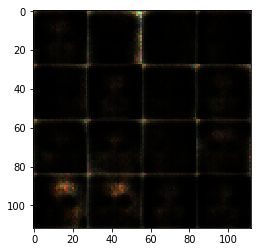

Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.7761... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.7951... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 2.4353... Generator Loss: 0.1663
Epoch 1/1... Discriminator Loss: 1.9689... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.9372... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 1.8140... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 0.9026


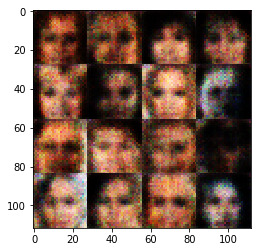

Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.8015
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 2.1718
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.6382
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.0728


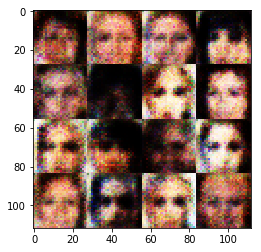

Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 2.2037
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.9230... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 2.0106... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.8147... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5133


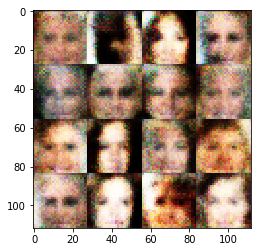

Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 1.0859


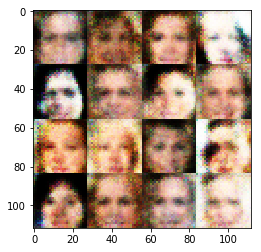

Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.9198
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.3577
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.5637
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8781


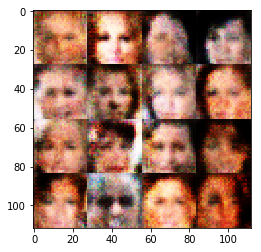

Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.8801
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 1.6178


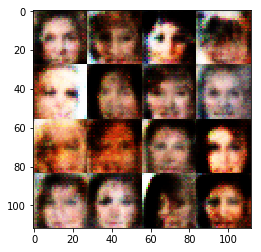

Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 2.4855
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.7929... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.1930


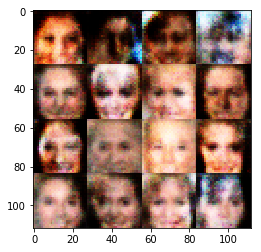

Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 2.3743
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 2.2564
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.4330
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 2.4273


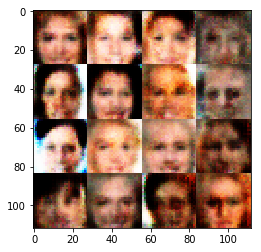

Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 2.0564
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 2.0033
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.9268


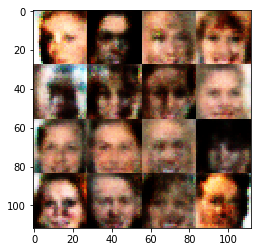

Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 2.1083
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.6160


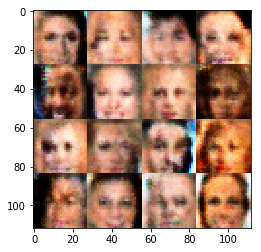

Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 2.1342
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.7165
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 1.9867... Generator Loss: 0.2462


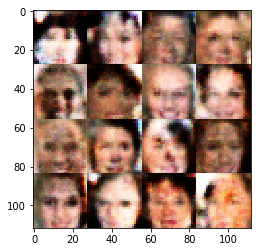

Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.9739... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.6223
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.9462


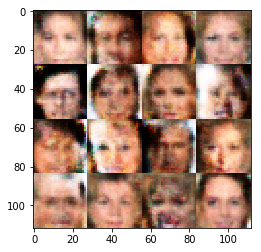

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8587


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.